
# I will be working with a Tweets Dataset to look into overfitting in NLP 
***




In [ ]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [ ]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9
#vocab_size = 10000


In [ ]:
SENTIMENT_CSV = "./data/training_cleaned.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



In [ ]:
def parse_data_from_file(filename):
    
    sentences = []
    labels = []
    
    with open(filename, 'r') as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        
        for row in reader:
            sentences.append(row[5])
            if row[0] == '0':
                labels.append(0)
            else: 
                labels.append(1)
        
            
            
        
   
        
    return sentences, labels




In [ ]:
# Test the function
sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


In [ ]:

sentences_and_labels = list(zip(sentences, labels))


random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)


sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")


There are 160000 sentences and 160000 labels after random sampling



## Training - Validation Split

***

In [ ]:
def train_val_split(sentences, labels, training_split):
    
    
    
    
    train_size = int(len(sentences) * training_split)

    
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
   
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:

train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


## Tokenization 

***

In [ ]:
def fit_tokenizer(train_sentences, oov_token):
    
  
    
    tokenizer = Tokenizer(num_words = 10000,  oov_token = oov_token)
    
    
    tokenizer.fit_on_texts(train_sentences)
    
  
    
    
    
    return tokenizer

In [ ]:

tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128293 words

<OOV> token included in vocabulary

index of word 'i' should be 2


In [ ]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    
    
       
    
    sequences = tokenizer.texts_to_sequences(sentences)
    
    
    pad_trunc_sequences = pad_sequences(sequences, padding = padding, maxlen = maxlen, truncating = truncating)
    
    
    
    return pad_trunc_sequences

In [ ]:

train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)



In [ ]:

GLOVE_FILE = './data/glove.6B.100d.txt'


GLOVE_EMBEDDINGS = {}


with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [ ]:
test_word = 'man'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word man looks like this:

[ 3.7293e-01  3.8503e-01  7.1086e-01 -6.5911e-01 -1.0128e-03  9.2715e-01
  2.7615e-01 -5.6203e-02 -2.4294e-01  2.4632e-01 -1.8449e-01  3.1398e-01
  4.8983e-01  9.2560e-02  3.2958e-01  1.5056e-01  5.7317e-01 -1.8529e-01
 -5.2277e-01  4.6191e-01  9.2038e-01  3.1001e-02 -1.6246e-01 -4.0567e-01
  7.8621e-01  5.7722e-01 -5.3501e-01 -6.8228e-01  1.6987e-01  3.6310e-01
 -7.1773e-02  4.7233e-01  2.7806e-02 -1.4951e-01  1.7543e-01 -3.7573e-01
 -7.8517e-01  5.8171e-01  8.6859e-01  3.1445e-02 -4.5897e-01 -4.0917e-02
  9.5897e-01 -1.6975e-01  1.3045e-01  2.7434e-01 -6.9485e-02  2.2402e-02
  2.4977e-01 -2.1536e-01 -3.2406e-01 -3.9867e-01  6.8613e-01  1.7923e+00
 -3.7848e-01 -2.2477e+00 -7.7025e-01  4.6582e-01  1.2411e+00  5.7756e-01
  4.1151e-01  8.4328e-01 -5.4259e-01 -1.6715e-01  7.3927e-01 -9.3477e-02
  9.0278e-01  5.0889e-01 -5.0031e-01  2.6451e-01  1.5443e-01 -2.9432e-01
  1.0906e-01 -2.6667e-01  3.5438e-01  4.9079e-02  1.8018e-01 -5.8590e-01

In [ ]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [ ]:

EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

Now you have the pre-trained embeddings ready to use!

In [ ]:

def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    
    
    
    model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], 
                                  trainable=False), 
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(24, activation = 'relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
                  
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

    

    return model

In [ ]:

model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)


history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

<table><tr><td><img src='images/invalid-1.jpg'></td></tr></table>

In [ ]:
import pandas as pd

df = pd.DataFrame(history.history)
df.tail(5)

,loss,accuracy,val_loss,val_accuracy
15,0.297130,0.865410,0.708205,0.730313
16,0.286537,0.869313,0.731202,0.732875
17,0.279782,0.874104,0.789511,0.724437
18,0.271007,0.878313,0.794526,0.726875
19,0.265119,0.880618,0.801726,0.725750


Run the following cell to check your loss curves:

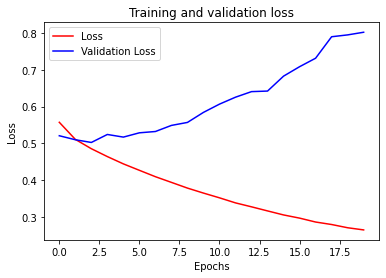

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]


plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

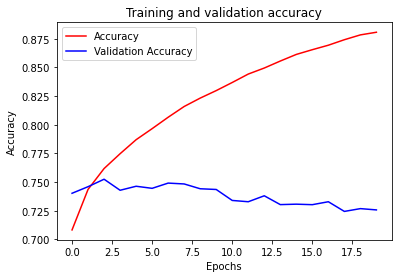

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [ ]:

slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is 0.01663


In [ ]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)